In [1]:
import orjson
import matplotlib.pyplot as plt
from snsphd import viz
from snsphd.help import prinfo
import numpy as np
from IPython.display import JSON
from enum import Enum
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from qutip import *

from util import (
    TomoCounts,
    Bin,
    Phase,
    create_matrix_row,
    print_matrix,
    shiftedColorMap,
)


Colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)

from typing import List
from pydantic import BaseModel, validator, Field

from snsphd.obj import DataObj

In [2]:
from custom_model_dm import (
    PowerRamp,
    ValueIntegrateExtraData,
    ExtremumResults,
    pretty_print_model,
)

In [3]:
with open("../data/high_power_scan/1/low_power/s_min_power_ramp.json", "rb") as f:
    data_min = orjson.loads(f.read())

with open("../data/high_power_scan/1/low_power/s_d90_power_ramp.json", "rb") as f:
    data_90 = orjson.loads(f.read())

with open("../data/high_power_scan/1/low_power/s_max_derived_power_ramp.json", "rb") as f:
    data_max_derived = orjson.loads(f.read())

In [4]:
with open("../data/high_power_scan/2/high_power/s_min_power_ramp.json", "rb") as f:
    hp_data_min = orjson.loads(f.read())

with open("../data/high_power_scan/2/high_power/s_d90_power_ramp.json", "rb") as f:
    hp_data_90 = orjson.loads(f.read())

with open("../data/high_power_scan/2/high_power/s_max_derived_power_ramp.json", "rb") as f:
    hp_data_max_derived = orjson.loads(f.read())

In [5]:
ramp_min = PowerRamp(**data_min)
ramp_max = PowerRamp(**data_max_derived)
ramp_90 = PowerRamp(**data_90)

In [6]:
hp_ramp_min = PowerRamp(**hp_data_min)
hp_ramp_max = PowerRamp(**hp_data_max_derived)
hp_ramp_90 = PowerRamp(**hp_data_90)

In [7]:
pretty_print_model(ramp_max, max_depth=4)

  -- 
 name: PowerRamp
   state :finished
   label :default_label
   results <list>
     0 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     1 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     2 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: SimpleSet
         ...
     3 -- 
     name: ScanStep
       label :default_label
       results <list>
         0 -- 
         name: SetPower
         ...
         1 -- 
         name: Wait
         ...
         2 -- 
         name: Sim

In [8]:
from typing import Union, get_origin, get_args


def print_string_or_none(value: Union[str, None]):
    if get_origin(Union) == type(value) and str in get_args(Union):
        print(value)
    else:
        print("NaN")

In [9]:
from typing import Union, get_origin, get_args
from dataclasses import dataclass


@dataclass
class MyClass:
    name: str
    value: Union[str, None]

    def print_value(self):
        if get_origin(Union) == type(self.value) and str in get_args(Union):
            print(f"{self.name}: {self.value}")
        else:
            print(f"{self.name}: NaN")

In [10]:
pretty_print_model(ramp_min.results[3].results[2])

  -- 
 name: Extremum
   results -- 
     counts_list <list>
       0 :804
       1 :814
       2 :805
       3 :805
       4 :804
       5 :802
       6 :808
     times_list <list>
       0 :9.574488878250122
       1 :8.840016841888428
       2 :9.14277982711792
       3 :9.54752516746521
       4 :10.320809364318848
       5 :10.473568677902222
       6 :10.96420669555664
     direction_array <list>
     voltage_list <list>
       0 :2.5387499999999985
       1 :2.5349999999999984
       2 :2.5387499999999985
       3 :2.5424999999999986
       4 :2.546249999999999
       5 :2.549999999999999
       6 :2.553749999999999
   integration_results <list>
     0 -- 
     name: ValueIntegrateExtraData
       label :default_label
       counts :804
       delta_time :9.574488878250122
       coincidences_hist_1 :...data...type: <class 'numpy.float64'>
       coincidences_hist_2 :...data...type: <class 'numpy.float64'>
       full_coinc_1 :...data...type: <class 'numpy.float64'>
       full_

In [11]:
# ramp_90.results[3]


class DMData(BaseModel):
    phase_90: List[ValueIntegrateExtraData]
    phase_min_res: ExtremumResults
    phase_min: List[ValueIntegrateExtraData]
    phase_max: List[ValueIntegrateExtraData]
    # phase_max_res: ExtremumResults


power_steps: List[DMData] = []
powers = []

# have the minus 2 because the last step of each is a set-voltage type, not a measurement
for i in range(len(ramp_90.results) + len(hp_ramp_90.results) - 2):

    # have the minus 1 because the last step is a set-voltage type, not a measurement
    if i < len(ramp_90.results) - 1:
        scan_step_90 = ramp_90.results[i]
        scan_step_min = ramp_min.results[i]
        scan_step_max = ramp_max.results[i]
    else:
        scan_step_90 = hp_ramp_90.results[i - len(ramp_90.results) + 1]
        scan_step_min = hp_ramp_min.results[i - len(ramp_90.results) + 1]
        scan_step_max = hp_ramp_max.results[i - len(ramp_90.results) + 1]

    # pretty_print_model(scan_step_90.results)

    powers.append(scan_step_90.results[0].results.expected_amps)
    #    scan_step_min.results[0].result.expected_amps,
    #    scan_step_max.results[0].result.expected_amps])

    # you WILL be changing these when you switch to singleSet for the 90 and max phase settings
    int_results_90: List[ValueIntegrateExtraData] = scan_step_90.results[2].results
    int_results_min: List[ValueIntegrateExtraData] = scan_step_min.results[
        2
    ].integration_results
    int_results_min_res: ExtremumResults = scan_step_min.results[2].results
    int_results_max_res: ExtremumResults = scan_step_max.results[2].results

    int_results_max = scan_step_max.results[2].results

    power_steps.append(
        DMData(
            phase_90=int_results_90,
            phase_min=int_results_min,
            phase_max=int_results_max,
            phase_min_res=int_results_min_res,
        )
    )
print("powers: ", powers)

powers:  [1.2922, 1.9835, 2.3658, 2.6637, 2.9165, 3.1399, 3.3424, 3.5289, 3.7027, 3.866, 4.0207, 4.1678, 4.3084, 4.4434, 4.5733, 4.6987, 4.8199, 4.9375, 5.0517, 5.1628]


140


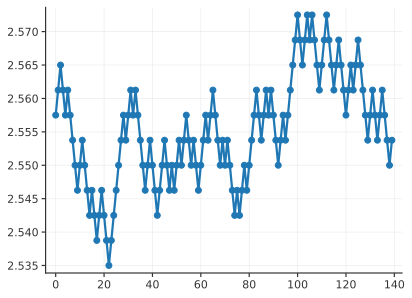

<Figure size 1600x1200 with 0 Axes>

In [12]:
voltages = []
counts = []
times = []

max_counts = []
max_times = []

singles_A = []
singles_B = []
coincidences = []

for i, power in enumerate(power_steps):
    # print(power.phase_min_res.voltage_list)
    voltages.extend(power.phase_min_res.voltage_list)
    counts.append(power.phase_min_res.counts_list)
    times.append(power.phase_min_res.times_list)
    # max_counts.append(power.phase_max_res.counts_list)
    # max_times.append(power.phase_max_res.times_list)

    sub_Sa = []
    sub_Sb = []
    sub_Cc = []
    delta_times = []
    for sect in power.phase_90:
        sub_Sa.append(np.sum(sect.singles_hist_1) / sect.delta_time)
        sub_Sb.append(np.sum(sect.singles_hist_2) / sect.delta_time)
        sub_Cc.append(sect.total_coincidences / sect.delta_time)
        delta_times.append(sect.delta_time)

        # if i > (len(power_steps) - 5):
        #     print(
        #         "Sa:",
        #         np.sum(sect.singles_hist_1) / sect.delta_time,
        #         "Sb:",
        #         np.sum(sect.singles_hist_2) / sect.delta_time,
        #         "Cc:",
        #         sect.total_coincidences / sect.delta_time,
        #         "dt:",
        #         sect.delta_time,
        #     )
        Sa = np.sum(sect.singles_hist_1) / sect.delta_time
        Sb = np.sum(sect.singles_hist_2) / sect.delta_time
        Cc = sect.total_coincidences / sect.delta_time
    # print()

    # I'm only collecting stats from one of the data runs for each power here. Could do some averaging if needed.
    singles_A.append(np.average(sub_Sa[1:]))
    singles_B.append(np.average(sub_Sb[1:]))
    coincidences.append(np.average(sub_Cc[1:]))

plt.plot(voltages, "-o")
print(len(voltages))
plt.figure()

counts_avg = np.average(counts, axis=1)
counts_std = np.std(counts, axis=1)

times_avg = np.average(times, axis=1)
times_std = np.std(times, axis=1)


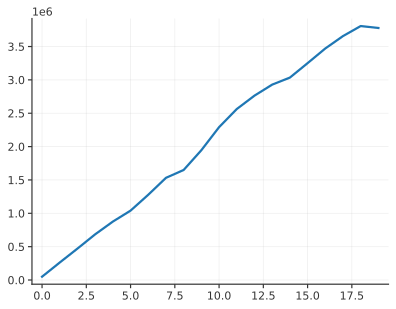

In [13]:
plt.plot(singles_A)

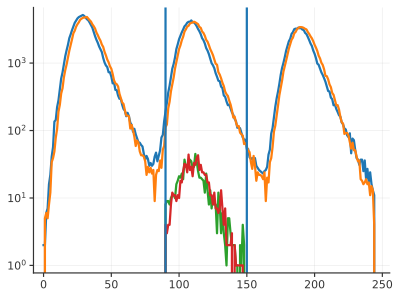

In [14]:
power_idx = 1
iter_idx = 0
hist1, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_1, bins=np.arange(250)
)
hist2, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].full_coinc_2, bins=np.arange(250)
)

hist1_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_1, bins=np.arange(250)
)
hist2_i, bins = np.histogram(
    power_steps[power_idx].phase_min[iter_idx].coincidences_hist_2, bins=np.arange(250)
)

plt.plot(bins[:-1], hist1)
plt.plot(bins[:-1], hist2)

plt.plot(bins[:-1], hist1_i)
plt.plot(bins[:-1], hist2_i)
plt.yscale("log")
plt.axvline(x=90)
plt.axvline(x=150)

In [15]:
def expected_chance_coincidence_rate(Sa, Sb, geo_factor, eta_a, eta_b):
    R = 4e9
    # [events from outside filter overlap] paired with [events outside filter overlap]
    alt_wavelength_alt_wavelength = ((1-geo_factor)*Sa/R)*((1-geo_factor)*Sb/R)

    # [events captured by filter A and outside filter B] paired with [entangled members present at B which got lost on way to A]
    alt_wl_center_1 = ((1-geo_factor)*(Sa/R))*(geo_factor*(Sb/R)*(1-eta_a))

    # [events captured by filter B and outside filter A] paired with [entangled members present at A which got lost on way to B]
    alt_wl_center_2 = ((1-geo_factor)*(Sb/R))*(geo_factor*(Sa/R)*(1-eta_b))

    P1 = alt_wavelength_alt_wavelength*(1-alt_wl_center_1)*(1-alt_wl_center_2)
    P2 = (1 - alt_wavelength_alt_wavelength)*alt_wl_center_1*(1-alt_wl_center_2)
    P3 = (1 - alt_wavelength_alt_wavelength)*(1-alt_wl_center_1)*alt_wl_center_2

    return R*(P1+ P2 + P3)

In [16]:
# this takes a while


# idx = 5 # goes over the repeated integrations


class ArrayData(BaseModel):
    avg: np.ndarray  # ultimately gets converted to np.ndarray, but 'list' keeps mypy happy
    std: np.ndarray

    @validator("avg", "std", pre=True)
    def to_numpy_float(cls, value) -> np.ndarray:
        return np.array(value, dtype=float)

    class Config:
        arbitrary_types_allowed = True


class TomoOutput(BaseModel):
    fidelities: ArrayData
    fidelities_sub: ArrayData
    rates: ArrayData
    log_negativities: ArrayData
    coherent_infos: ArrayData
    car_mu: ArrayData
    qber: ArrayData
    visibilities: ArrayData
    visibilities_sub: ArrayData


class ThisPowerTomoOutput(BaseModel):
    this_power_tomos: list
    this_power_coherent_infos: list
    this_power_log_negativities: list
    this_power_fidelities: list
    this_power_fidelities_sub: list
    this_power_rates: list
    this_power_car_mu: list
    this_power_qber: list
    this_power_visibilities: list
    this_power_visibilities_sub: list


def tomo_from_power_step(
    step: DMData,
    print_output: bool = False,
    bin_ranges: list[list[int]] = [[0, 75], [85, 155], [165, 240]],
    verbose: bool = False,
) -> ThisPowerTomoOutput:
    """
    Takes a power step and returns the tomography results
    """
    this_power_coherent_infos = []
    this_power_log_negativities = []
    this_power_fidelities = []
    this_power_fidelities_sub = []
    this_power_rates = []
    this_power_tomos = []
    this_power_car_mu = []
    this_power_qber = []
    this_power_visibilities = []
    this_power_visibilities_sub = []
    for idx in range(
        2, len(step.phase_max)
    ):  # the number of integrations in each power
        # ddic = step.phase_max[idx]

        tomo = TomoCounts()

        tags_1 = step.phase_90[idx].full_coinc_1
        tags_2 = step.phase_90[idx].full_coinc_2

        tags_in_guard_region_1 = np.bitwise_or(
            [(tags_1 > bin_ranges[0][1]) & (tags_1 < bin_ranges[1][0])],
            [(tags_1 > bin_ranges[1][1]) & (tags_1 < bin_ranges[2][0])],
        )
        tags_in_guard_region_2 = np.bitwise_or(
            [(tags_2 > bin_ranges[0][1]) & (tags_2 < bin_ranges[1][0])],
            [(tags_2 > bin_ranges[1][1]) & (tags_2 < bin_ranges[2][0])],
        )

        print("tags in 1: ", np.sum(tags_in_guard_region_1))
        print("tags in 2: ", np.sum(tags_in_guard_region_2))

        tags_in_guard_regions = np.logical_or(
            tags_in_guard_region_1, tags_in_guard_region_2
        )
        print("guard region filtered tags: ", np.sum(tags_in_guard_regions))

        total_rate = (
            len(step.phase_90[idx].full_coinc_1) - np.sum(tags_in_guard_regions)
        ) / step.phase_90[idx].delta_time

        print("total rate 1: ", total_rate)
        print(
            "total rate 2: ",
            len(step.phase_90[idx].full_coinc_1) / step.phase_90[idx].delta_time,
        )
        print(
            "total rate 3: ",
            8
            * step.phase_min[idx].total_coincidences
            / (6 * step.phase_min[idx].delta_time),
        )
        print()

        if print_output:
            print("total rate: ", total_rate)
            print("length: ", len(step.phase_90[idx].full_coinc_1))
            print("delta time: ", step.phase_90[idx].delta_time)

        singles_rate_A = (
            np.sum(step.phase_min[idx].singles_hist_1) / step.phase_min[idx].delta_time
        )
        singles_rate_B = (
            np.sum(step.phase_min[idx].singles_hist_2) / step.phase_min[idx].delta_time
        )
        if print_output:
            print("singles rate A: ", singles_rate_A)
            print("singles rate B: ", singles_rate_B)
            
        ratio_of_singles_A_in_center_bin = np.sum(
            step.phase_min[idx].singles_hist_1[80:160]
        ) / np.sum(step.phase_min[idx].singles_hist_1)
        ratio_of_singles_B_in_center_bin = np.sum(
            step.phase_min[idx].singles_hist_2[80:160]
        ) / np.sum(step.phase_min[idx].singles_hist_2)
            
        if print_output:
            print(
                "ratio of singles A in center bin: ", ratio_of_singles_A_in_center_bin
            )
            print(
                "ratio of singles B in center bin: ", ratio_of_singles_B_in_center_bin
            )

        singles_center_A_rate = (
            ratio_of_singles_A_in_center_bin * singles_rate_A
        )  # * (1 - 0.393) # 0.393 is the geometric factor
        singles_center_B_rate = (
            ratio_of_singles_B_in_center_bin * singles_rate_B
        )  # * (1 - 0.393) # 0.393 is the geometric factor

        chance_rate = expected_chance_coincidence_rate(singles_center_A_rate, singles_center_B_rate, 0.393, 0.18, 0.21)
        print("rate of chance coincidences: ", chance_rate)

        tomo.fill(
            Phase.DD,
            step.phase_max[idx].full_coinc_1,
            step.phase_max[idx].full_coinc_2,
            step.phase_max[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.DR,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RD,
            step.phase_90[idx].full_coinc_1,
            step.phase_90[idx].full_coinc_2,
            step.phase_90[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.fill(
            Phase.RR,
            step.phase_min[idx].full_coinc_1,
            step.phase_min[idx].full_coinc_2,
            step.phase_min[idx].delta_time,
            bin_ranges=bin_ranges,
        )

        tomo.calculate_density_matrix()

    
        fidelity_sub = tomo.calculate_fidelity(dcr_subtraction=chance_rate)
        fidelity = tomo.calculate_fidelity()

        if print_output:
            print("rate in minimized center bin: ", tomo.rr[-1])

        log_negativity = tomo.calculate_log_negativity(tomo.rho)
        coherent_info = tomo.calculate_coherent_information(tomo.rho)

        this_power_log_negativities.append(log_negativity)
        this_power_coherent_infos.append(coherent_info)

        this_power_qber.append(tomo.calculate_qber())
        this_power_visibilities.append(tomo.calculate_visibility())
        this_power_visibilities_sub.append(tomo.calculate_visibility(dcr_subtraction=chance_rate))

        this_power_fidelities.append(fidelity)
        this_power_fidelities_sub.append(fidelity_sub)
        this_power_rates.append(total_rate)
        this_power_tomos.append(tomo)
        this_power_car_mu.append(tomo.calculate_car_mu())
        if print_output:
            print("car mu: ", tomo.calculate_car_mu())

    return ThisPowerTomoOutput(
        this_power_tomos=this_power_tomos,
        this_power_coherent_infos=this_power_coherent_infos,
        this_power_log_negativities=this_power_log_negativities,
        this_power_fidelities=this_power_fidelities,
        this_power_fidelities_sub=this_power_fidelities_sub,
        this_power_rates=this_power_rates,
        this_power_car_mu=this_power_car_mu,
        this_power_qber=this_power_qber,
        this_power_visibilities=this_power_visibilities,
        this_power_visibilities_sub=this_power_visibilities_sub,
    )


def do_tomography_and_export_metrics(
    power_steps: List[DMData], print_output=False
) -> tuple[TomoOutput, list[list[TomoCounts]]]:
    coherent_infos_avg = []
    coherent_infos_std = []

    log_negativities_avg = []
    log_negativities_std = []

    fidelities_avg = []
    fidelities_std = []

    fidelities_sub_avg = []
    fidelities_sub_std = []

    car_mu_avg = []
    car_mu_std = []

    rates_avg = []
    rates_std = []
    tomos = []

    qber_avg = []
    qber_std = []

    visibilities_avg = []
    visibilities_std = []

    visibilities_sub_avg = []
    visibilities_sub_std = []

    for i in range(len(power_steps)):
        step: DMData = power_steps[i]
        t = tomo_from_power_step(step, print_output)

        # print(t)
        coherent_infos_avg.append(np.average(t.this_power_coherent_infos))
        coherent_infos_std.append(np.std(t.this_power_coherent_infos))
        log_negativities_avg.append(np.average(t.this_power_log_negativities))
        log_negativities_std.append(np.std(t.this_power_log_negativities))

        fidelities_avg.append(np.average(t.this_power_fidelities))
        fidelities_std.append(np.std(t.this_power_fidelities))

        fidelities_sub_avg.append(np.average(t.this_power_fidelities_sub))
        fidelities_sub_std.append(np.std(t.this_power_fidelities_sub))


        qber_avg.append(np.average(t.this_power_qber))
        qber_std.append(np.std(t.this_power_qber))

        # prinfo(fidelities_avg)
        # prinfo(fidelities_std)
        rates_avg.append(np.average(t.this_power_rates))
        rates_std.append(np.std(t.this_power_rates))
        car_mu_avg.append(np.average(t.this_power_car_mu))
        car_mu_std.append(np.std(t.this_power_car_mu))
        tomos.append(t.this_power_tomos)

        visibilities_avg.append(np.average(t.this_power_visibilities))
        visibilities_std.append(np.std(t.this_power_visibilities))

        visibilities_sub_avg.append(np.average(t.this_power_visibilities_sub))
        visibilities_sub_std.append(np.std(t.this_power_visibilities_sub))

    output = TomoOutput(
        fidelities=ArrayData(avg=fidelities_avg, std=fidelities_std),
        fidelities_sub=ArrayData(avg=fidelities_sub_avg, std=fidelities_sub_std),
        rates=ArrayData(avg=rates_avg, std=rates_std),
        log_negativities=ArrayData(avg=log_negativities_avg, std=log_negativities_std),
        coherent_infos=ArrayData(avg=coherent_infos_avg, std=coherent_infos_std),
        car_mu=ArrayData(
            avg=car_mu_avg,
            std=car_mu_std,
        ),
        qber=ArrayData(
            avg=qber_avg,
            std=qber_std,
        ),
        visibilities=ArrayData(
            avg=visibilities_avg,
            std=visibilities_std,
        ),
        visibilities_sub=ArrayData(
            avg=visibilities_sub_avg,
            std=visibilities_sub_std,
        ),
    )

    return output, tomos

In [17]:
tomography_result, tomos = do_tomography_and_export_metrics(
    power_steps, print_output=False
)

tags in 1:  414
tags in 2:  288
guard region filtered tags:  701
total rate 1:  1901.9855945817508
total rate 2:  1909.9958073304113
total rate 3:  1898.7991586119665

rate of chance coincidences:  0.13026714994754515
tags in 1:  465
tags in 2:  277
guard region filtered tags:  740
total rate 1:  1856.0060752835227
total rate 2:  1864.229555184788
total rate 3:  1870.7863004323222

rate of chance coincidences:  0.1262917634739337
tags in 1:  415
tags in 2:  267
guard region filtered tags:  682
total rate 1:  1814.8580990756548
total rate 2:  1822.2797633952364
total rate 3:  1887.6817665698688

rate of chance coincidences:  0.12878532674165738
tags in 1:  491
tags in 2:  239
guard region filtered tags:  730
total rate 1:  1801.9375895092667
total rate 2:  1809.817059267277
total rate 3:  1905.621007160178

rate of chance coincidences:  0.13155032510784798
tags in 1:  441
tags in 2:  241
guard region filtered tags:  682
total rate 1:  1827.2453584031273
total rate 2:  1834.741681976001


c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 3400.
  warnings.warn(errors[info][0], RuntimeWarning)


tags in 1:  519
tags in 2:  385
guard region filtered tags:  904
total rate 1:  25935.739857852917
total rate 2:  26075.95987622225
total rate 3:  26357.106023789045

rate of chance coincidences:  22.040390311312898
tags in 1:  485
tags in 2:  368
guard region filtered tags:  853
total rate 1:  25978.69410483394
total rate 2:  26112.335165234766
total rate 3:  26251.096939551997

rate of chance coincidences:  22.005168378981676
tags in 1:  450
tags in 2:  376
guard region filtered tags:  824
total rate 1:  26016.62339789478
total rate 2:  26145.230035765013
total rate 3:  26259.75059828221

rate of chance coincidences:  21.99157988976346
tags in 1:  533
tags in 2:  395
guard region filtered tags:  927
total rate 1:  32880.18128348617
total rate 2:  33063.63174963558
total rate 3:  33646.297401030286

rate of chance coincidences:  36.33701010178344
tags in 1:  490
tags in 2:  421
guard region filtered tags:  910
total rate 1:  32825.137424022476
total rate 2:  33006.33446050868
total ra

In [18]:
tomography_result.rates

ArrayData(avg=array([  1840.40654337,  10034.85768421,  17948.14336697,  25964.18219248,
        32978.36509817,  38805.3682061 ,  47475.21053343,  56697.72954934,
        60347.35942366,  70973.16263002,  84025.35684367,  92976.88407737,
        99845.33030514, 105345.06925386, 108566.06247185, 115708.7780465 ,
       122531.81491605, 127882.54097413, 132879.79938267, 131593.90963779]), std=array([  35.61214723,   24.51984704,   34.23538597,   60.60632262,
        107.89745691,  138.53960966,  237.93529139,  235.17046946,
        170.26675737,  395.24341264,  606.59239299,  212.29501054,
        315.79902854,  441.94353498,  743.07839225,  458.41873641,
        500.40846558, 1021.69080319,  422.61294659, 1214.27037356]))

In [19]:
tomography_result.fidelities

ArrayData(avg=array([99.58561568, 99.51592887, 99.40135835, 99.30187354, 99.24726423,
       99.18162697, 99.1289778 , 98.96789436, 98.87707423, 98.82683158,
       98.67339859, 98.4729103 , 98.425306  , 98.24055214, 98.06630267,
       98.00170946, 97.84333789, 97.85246913, 97.77424788, 97.75414247]), std=array([0.01478122, 0.00602062, 0.02364012, 0.04808761, 0.01835207,
       0.03382338, 0.0122387 , 0.02439691, 0.03739825, 0.02786588,
       0.05725968, 0.0525862 , 0.07456249, 0.04800004, 0.03566622,
       0.04801137, 0.08275623, 0.03885422, 0.06281305, 0.03879058]))

In [20]:

from snsphd.layout import bisect
from snsphd.obj import DataObj
from snsphd.viz import plot_arrows

create_guard_region_scan_plot = False

if create_guard_region_scan_plot:

    # investivate how visibilities change with guard region size

    visibilities_guard_scan_avg = []
    visibilities_guard_scan_std = []
    guard_sizes = []
    coherent_infos_guard_scan_avg = []
    coherent_infos_guard_scan_std = []
    rates_guard_scan_avg = []
    for x in range(0, 40, 4):
        guard_sizes.append(2*x)
        bin_range = [[0, 80-x], [80+x, 160-x], [160+x, 240]]
        print(bin_range)
        t = tomo_from_power_step(power_steps[0], print_output=False, bin_ranges = bin_range)
        visibilities_guard_scan_avg.append(np.average(t.this_power_visibilities))
        visibilities_guard_scan_std.append(np.std(t.this_power_visibilities))
        coherent_infos_guard_scan_avg.append(np.average(t.this_power_coherent_infos))
        coherent_infos_guard_scan_std.append(np.std(t.this_power_coherent_infos))
        rates_guard_scan_avg.append(np.average(t.this_power_rates))
        # print(t.this_power_visibilities)

    # if False:

    d = DataObj.from_file("histogram_data.json")

    fig = plt.figure(figsize = (11,3.2))

    left, right = bisect([0,0,1,1],direction="vert", offset=0.6, spacing=0.13, absolute_spacing=True)
    bottom_right, top_right = bisect(right, direction="horiz", offset=0.5, spacing=0.09, absolute_spacing=True)

    hist = fig.add_axes(left)

    fids = fig.add_axes(top_right)
    rates = fig.add_axes(bottom_right, sharex=fids)

    hist.plot(np.arange(0,len(d.coinc_min)-8), np.roll(d.coinc_min[:-8],8), '--', alpha=0.5, color="black", )
    hist.plot(np.arange(0,len(d.coinc_max)-8), np.roll(d.coinc_max[:-8],8), '-', alpha=0.5, color="grey")
    hist.set_yscale('log')
    hist.axvspan(70, 90, alpha=0.2, color='red')
    hist.axvspan(150, 170, alpha=0.2, color='red')
    plot_arrows(hist, (70, 8), (90, 8), color='red', alpha=0.5, lw=2, label="x", fontsize=16, arrowsize=15)
    plot_arrows(hist, (150, 8), (170, 8), color='red', alpha=0.5, lw=2, label="x", fontsize=16, arrowsize=15)

    fids.errorbar(guard_sizes, visibilities_guard_scan_avg, yerr=visibilities_guard_scan_std, fmt='o', elinewidth=4,
            alpha=0.4,ls='-', label='Visibility')
    fids.set_ylabel("Visibility (%)")
    rates.plot(guard_sizes, rates_guard_scan_avg, 'o', ls='-', label='Rate', alpha=0.5)
    rates.set_ylabel("Coincidence Rate (Hz)")
    rates.set_xlabel("Guard size x (ps)")
    rates.axvline(x=10, ls='--', color='red', alpha=0.5)
    fids.axvline(x=10, ls='--', color='red', alpha=0.5)
    fids.set_title(r"visibility and rate vs guard widths, $\mu$ = 3.6e-5")

    hist.set_xlabel("time (ps)")
    hist.set_ylabel("Coincidences (Hz/ps)")


    viz.save_light_dark_all(fig, "../figs/guard_scan", override_alpha=True)

In [21]:
tomo = tomos[-1][-1]

print(tomo)
tomo.calculate_coherent_information(tomo.rho)
tomo.calculate_visibility()

phase		|dd>		|dr>		|rd>		|rr>
ee: 		21815.5768	20930.7557	20930.7557	21265.0361	
el: 		491.3911	428.0822	428.0822	509.5699	
ed: 		19026.3706	0.0		18326.9774	0.0		
er: 		0.0		18326.9774	0.0		18759.6508	
le: 		444.0134	426.0849	426.0849	422.1064	
ll: 		12670.4792	12182.034	12182.034	12520.5886	
ld: 		15326.6636	0.0		14197.2825	0.0		
lr: 		0.0		14197.2825	0.0		14391.5467	
de: 		17963.411	17184.5372	0.0		0.0		
dl: 		16246.8829	15444.9124	0.0		0.0		
dd: 		65615.5891	0.0		0.0		0.0		
dr: 		0.0		33064.1893	0.0		0.0		
re: 		0.0		0.0		17184.5372	17559.2461	
rl: 		0.0		0.0		15444.9124	15233.2243	
rd: 		0.0		0.0		33064.1893	0.0		
rr: 		0.0		0.0		0.0		1458.3586	



95.6514901835724

In [22]:
import json
with open("mcr.json", "r") as file:
    mcr_data = json.load(file)

# mcr_data.keys()
mcr_count_rates = mcr_data["count_rates"]
mcr_eff_efficiencies = mcr_data["eff_efficiencies"]

In [23]:
# explained in the supplemental section "Coincidence Rate & Interferometer Output Ports"

# these extrapolate coincidence rates for 2 and 4 branches of the full wavefunction, given rates for the one branch measured
def one_branch_to_two_branch(entanglement_rate):
    Ra = 0.99
    return entanglement_rate*(1 + Ra)

def two_branch_to_four_branch(entanglement_rate):
    Ra = 0.99
    Rb = 1.04
    return entanglement_rate*(1 + Ra + Rb + Ra*Rb)/(1 + Ra)

In [24]:
singles_A_detector_efficiency_correction = np.interp(singles_A, mcr_count_rates, mcr_eff_efficiencies)
singles_A_linearized = singles_A / singles_A_detector_efficiency_correction

singles_B_detector_efficiency_correction = np.interp(singles_B, mcr_count_rates, mcr_eff_efficiencies)
singles_B_linearized = singles_B / singles_B_detector_efficiency_correction

# at first I thought you had to calculate what singles and coincidence rates you would have it detector efficiency didn't drop slightly with count rate
# however, if you correct for that effect, the correction shows up both S_A, S_B, and in C_AB. So the corrections cancel out. For this reason I do not include
# any such corrections here. 

# coincidences is multiplied by 2 to represent 2 branches of the total wavefunction. This is meant to reflect a more complete calculation of mu that 
# you could do if you measured all 4 outputs of Alice and Bobs interferometers: 
# mu = (S_{Alice+} + S_{Alice-})*(S_{Bob+} + S_{Bob-})*geometric_factor/(all_coincidences * 4e9)
# here, (S_{Alice+} + S_{Alice-}) is the sum of all singles rates from Alice's interferometer (outputs + and -) and is expected to be about double S_A we use here. Similarily for Bob. 
# all_coincidenes is expect to be about 4 times more tha 'coincidences' we use here.

geometric_factor = (
    0.393  # a result of the JSI modelling analysis: gamma_geo = 0.393 +/- 0.012
)

mus = (
    np.array(singles_A)
    * np.array(singles_B)
    * geometric_factor
    / (one_branch_to_two_branch(np.array(coincidences)) * 4e9)
)
print(f"this is singles_A_linearized: {singles_A_linearized[-1]}, and singles_B_linearized: {singles_B_linearized[-1]}, and geometric_factor: {geometric_factor}, and np.average(rates): {one_branch_to_two_branch(np.array(coincidences[-1]))}")


# mu_std = np.sqrt(p1**2 + p2**2 + p3**2)
p1 = ((np.array(singles_A)* geometric_factor)/(np.array(coincidences) * 4e9))*np.sqrt(singles_B)
p2 = ((np.array(singles_B)* geometric_factor)/(np.array(coincidences) * 4e9))*np.sqrt(singles_A)
p3 = ((np.array(singles_B) * np.array(singles_A)* geometric_factor)/((np.array(coincidences)**2) * 4e9))*np.sqrt(coincidences)
mu_std = np.sqrt(p1**2 + p2**2 + p3**2)
# prinfo(mu_std)
# prinfo(mus)

this is singles_A_linearized: 4223314.12827626, and singles_B_linearized: 4225947.878219032, and geometric_factor: 0.393, and np.average(rates): 265691.8019129614


In [25]:
tomography_result.qber.avg

array([0.00412672, 0.00481739, 0.00595074, 0.00693264, 0.00747109,
       0.00811719, 0.00863499, 0.01021556, 0.01110443, 0.01159557,
       0.01309202, 0.01504094, 0.01550229, 0.01729005, 0.01897003,
       0.01959119, 0.02111068, 0.02102367, 0.02177254, 0.02196513])

In [26]:
print(len(singles_A))

20


Text(0, 0.5, 'mu')

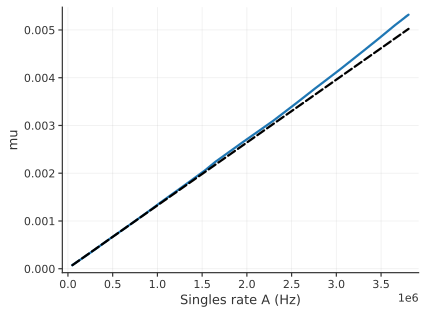

In [27]:
plt.plot(singles_A, mus)
fit = np.polyfit(singles_A[:3], mus[:3], 1)
fit_fn = np.poly1d(fit)
plt.plot(singles_A, fit_fn(singles_A), '--k')
plt.xlabel("Singles rate A (Hz)")
plt.ylabel("mu")
# we acctually expect \mu to increase faster than linearly with singles_A, because if you were to extrapolate to much higher pump powers, singes_A would plateau due to saturation of the detector, but \mu would keep increasing

# you would expect something like:


#    |          *
#    |          * 
#    |         *
#\mu |       *  
#    |    *     
#    |*
#    ------------|--
#        S_A   S_A_max



In [28]:
# find value cloest to 3.5e6 in mcr_count_rates
idx = np.argmin(np.abs(np.array(mcr_count_rates) - 3.5e6))
mcr_eff_efficiencies[idx]
eff_lost = round(100*(1 - mcr_eff_efficiencies[idx]))

print(f"""At the highest pump power we an acheive, we expect the 
detector to have lost about {eff_lost}% efficiency. This is 
consistent with the mismatch between the fitted line and \mu 
calculation above""")

At the highest pump power we an acheive, we expect the 
detector to have lost about 10% efficiency. This is 
consistent with the mismatch between the fitted line and \mu 
calculation above


Text(0.5, 1.0, 'visiblity vs mu')

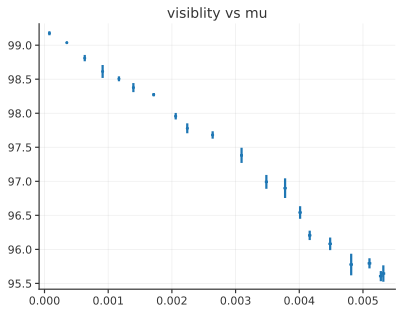

In [29]:
plt.errorbar(mus, tomography_result.visibilities.avg, xerr = mu_std, yerr=tomography_result.visibilities.std, fmt='o', markersize=2, capsize=0)
plt.title("visiblity vs mu")

In [30]:
tomography_result.visibilities.avg

array([99.17465579, 99.03652237, 98.80985246, 98.61347239, 98.50578261,
       98.37656223, 98.27300109, 97.95688747, 97.77911471, 97.68088545,
       97.38159682, 96.99181196, 96.89954244, 96.54199064, 96.20599441,
       96.08176105, 95.77786421, 95.79526517, 95.64549182, 95.60697481])

poly coeffs:  [ 0.00031424 -0.00058001  0.00024139]
[1.2922, 1.9835, 2.3658, 2.6637, 2.9165, 3.1399, 3.3424, 3.5289, 3.7027, 3.866, 4.0207, 4.1678, 4.3084, 4.4434, 4.5733, 4.6987, 4.8199, 4.9375, 5.0517, 5.1628]
mu: 0.0000, power: 1.4155
mu: 0.0003, power: 1.9500
mu: 0.0006, power: 2.2894
mu: 0.0008, power: 2.5598
mu: 0.0011, power: 2.7916
mu: 0.0013, power: 2.9976
mu: 0.0016, power: 3.1849
mu: 0.0018, power: 3.3578
mu: 0.0021, power: 3.5193
mu: 0.0023, power: 3.6713
mu: 0.0026, power: 3.8153
mu: 0.0029, power: 3.9525
mu: 0.0031, power: 4.0837
mu: 0.0034, power: 4.2097
mu: 0.0036, power: 4.3310
mu: 0.0039, power: 4.4482
mu: 0.0041, power: 4.5616
mu: 0.0044, power: 4.6715
mu: 0.0046, power: 4.7784
mu: 0.0049, power: 4.8823


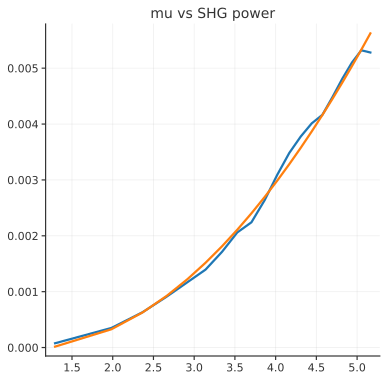

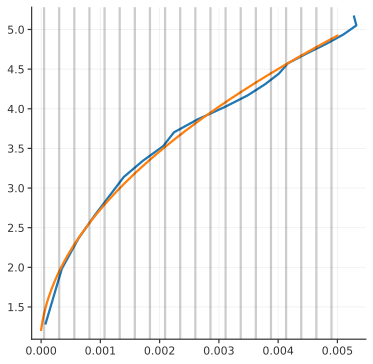

In [31]:
### powers (SHG amps) vs coincidence rates

class Parabola:
    def __init__(self, coeffs):
        self.coeffs = coeffs
    def __call__(self, x):
        x = np.array(x)
        return self.coeffs[0]*x**2 + self.coeffs[1]*x + self.coeffs[2]
    
    def inverse(self, y):
        a, b, c = self.coeffs
        x1 = (-b + np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        x2 = (-b - np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        return x1, x2

para = Parabola(np.polyfit(powers, mus, 2))

print("poly coeffs: ", np.polyfit(powers, mus, 2))

mus_temp = np.linspace(0, 0.005, 200)
# print(mus_temp)
print(powers)
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(powers, mus)
ax.plot(powers, para(powers))
ax.set_title("mu vs SHG power")


fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(mus, powers)
ax.plot(mus_temp, para.inverse(mus_temp)[0])

used_mus = np.linspace(0.005/20,0.0051, 20) - .0002
used_powers = para.inverse(used_mus)[0]


for p, mu in zip(used_powers, used_mus):
    print(f"mu: {mu:.4f}, power: {p:.4f}")

# print(used_powers)
for mu in used_mus:
    ax.axvline(mu, color="k", alpha=0.2)

In [32]:
@dataclass
class Line:
    slope: float
    intercept: float

    def __call__(self, x):
        return self.slope * x + self.intercept
    

@dataclass
class Line2:
    coefficients: List[float]

    def __call__(self, x):
        return sum(c * x**(len(self.coefficients)-1-i) for i, c in enumerate(self.coefficients))

Line(slope=4.6567997565175006, intercept=0.0014421631962937456)


Text(0, 0.5, 'mu defined from CAR')

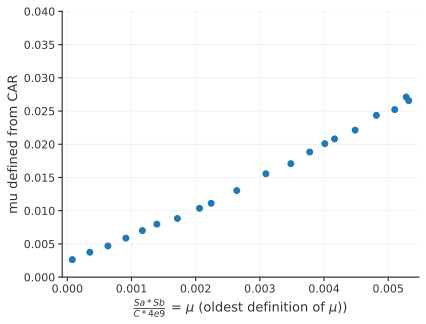

In [33]:
plt.plot(mus, tomography_result.car_mu.avg, "o")

coeffs = np.polyfit(mus, tomography_result.car_mu.avg, 1)
car_mu_line = Line(coeffs[0], coeffs[1])
print(car_mu_line)

car_mus = mus*car_mu_line.slope + car_mu_line.intercept
# plt.plot(mus, car_mus, label="car mu line")
plt.ylim(0,0.04)
plt.xlabel(r"$\frac{Sa*Sb}{C*4e9}$ = $\mu$ (oldest definition of $\mu$))")
plt.ylabel("mu defined from CAR")


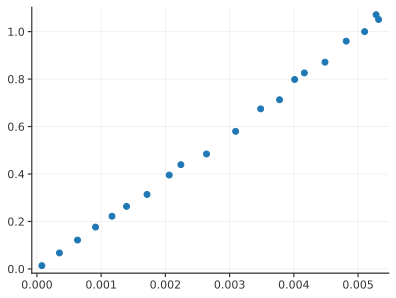

In [34]:
plt.plot(mus, tomography_result.fidelities_sub.avg - tomography_result.fidelities.avg, "o")
# viz.save_light_dark_all(name="test")

In [35]:
# extrapolate to 2 branches of the wavefunction
# 
tomography_result.rates.avg = 4*tomography_result.rates.avg

[0.31, 4.88, 10.13, 14.52, 18.33, 21.87]
['..', 'figs', 'shg_scan']
../figs/
pickleable


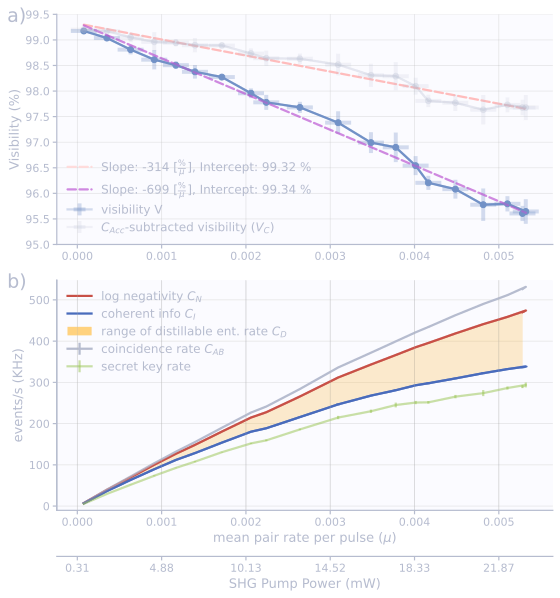

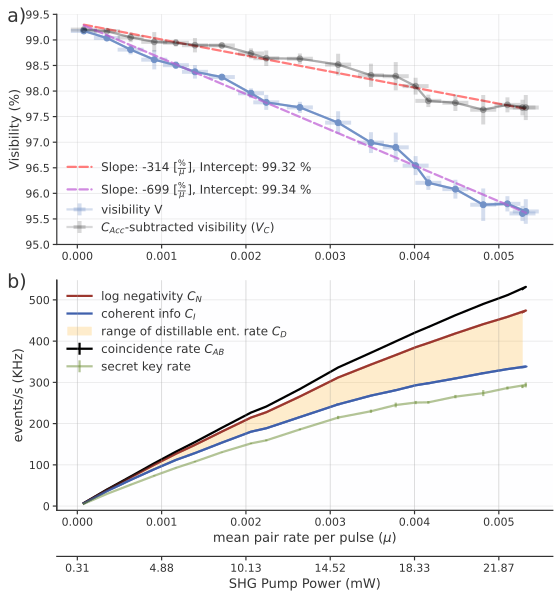

In [45]:
viz.update_colors(dark=False)

from scipy import interpolate
from snsphd.layout import bisect


fig = plt.figure(figsize=(6.9, 6.9))
divider_width = 0.09
master_bottom, master_top = bisect(
    [0, 0, 1, 1],
    direction="horiz",
    offset=0.5,
    spacing=divider_width * 0.8,
    absolute_spacing=True,
)


visibilities = fig.add_axes(master_top)
rates = fig.add_axes(master_bottom, sharex=visibilities)

powers = np.array(powers)


def comb(set1, set2):
    return np.sqrt(set1**2 + set2**2)


def plot_visibilities(ax, mus, res: TomoOutput, zoomed_out: bool = False) -> Line:
    # coeffs = np.polyfit(mus, y, 1)
    coeffs = np.polyfit(mus, res.visibilities_sub.avg, 1)
    visibility_sub_line = Line(coeffs[0], coeffs[1])

    coeffs = np.polyfit(mus, res.visibilities.avg, 1)
    visibility_line = Line(coeffs[0], coeffs[1])

    y = res.visibilities.avg
    if zoomed_out:
        # visibilities with errorbars
        ax.errorbar(
            mus,
            res.visibilities.avg,
            yerr=2 * res.visibilities.std,
            xerr=2*np.interp(np.sqrt(singles_A), xp=singles_A, fp=mus), # poisson uncertainty
            elinewidth=4,
            alpha=0.3,
            color=Colors["blue"],
            label="visibility",
            capsize=0
        )
        ax.plot(mus, y, "-o", color=Colors["blue"], markersize=4)

    else:
        ax.set_ylabel("Visibility (%)")

        # visibility noise subtracted fit line
        ax.plot(
            mus,
            visibility_sub_line.slope * mus + visibility_sub_line.intercept,
            color="#ff6e6e", # pink
            linestyle="--",
            label=rf"Slope: {visibility_sub_line.slope:.0f} ${{[\frac{{\%}}{{\mu}}]}}$, Intercept: {visibility_sub_line.intercept:.2f} %",
            alpha=0.9,
        )

        # visibilities with errorbars
        ax.errorbar(
            mus,
            res.visibilities.avg,
            yerr=2 * res.visibilities.std,
            xerr=2*np.interp(np.sqrt(singles_A), xp=singles_A, fp=mus), # poisson uncertainty
            elinewidth=4,
            alpha=0.3,
            color=Colors["blue"],
            label="visibility V",
            capsize=0
        )
        ax.plot(mus, y, "-o", color=Colors["blue"])

        # noise-subtracted visibility line
        ax.errorbar(
            mus,
            res.visibilities_sub.avg,
            yerr=2 * res.visibilities_sub.std,
            xerr=2*np.interp(np.sqrt(singles_A), xp=singles_A, fp=mus), # poisson uncertainty
            elinewidth=4,
            alpha=0.15,
            color="k",
            label="$C_{{Acc}}$-subtracted visibility ($V_C$)",
            capsize=0
        )
        ax.plot(mus, res.visibilities_sub.avg, "-o", color="k", alpha=0.2)

        ### visibility fit line
        ax.plot(
            mus,
            visibility_line.slope * mus + visibility_line.intercept,
            color="#bd59d4", # purple
            linestyle="--",
            label=rf"Slope: {visibility_line.slope:.0f} ${{[\frac{{\%}}{{\mu}}]}}$, Intercept: {visibility_line.intercept:.2f} %",
            alpha=0.7,
        )
        ax.set_yticks([99.5, 99, 98.5, 98, 97.5, 97, 96.5, 96, 95.5, 95])

    return visibility_line, visibility_sub_line


def secret_key_mult(q):
    # = 1 - 1.1H(q) - H(q) where 1.1 is the bidirectional error correction efficiency and H(q) is the binary entropy
    return (1 - 2.1 * (-q * np.log2(q) - (1 - q) * np.log2(1 - q)))


def secret_key_rate(raw_rate, q):
    # assuming imbalanced beam splitters that choose z basis with 90% probability on both alice and bob sides
    # 0.9*0.9 = 0.81
    return 0.81*raw_rate*secret_key_mult(q)



def plot_rates(ax, mus, res: TomoOutput, line_style="-", marker="none", markersize = 5, zoomed_out = False, scalar=1) -> tuple[Line, Line, Line]:



    ax.errorbar(
        mus,
        res.rates.avg * scalar,
        yerr=res.rates.std * scalar,
        label=r"coincidence rate $C_{AB}$",
        color="k",
        linestyle=line_style,
        marker=marker,
        markersize=markersize,
        capsize=0
    )

    
    rates_detector_corrected = res.rates.avg/(singles_A_detector_efficiency_correction*singles_B_detector_efficiency_correction)

    ## rates fit line
    coeffs_rates = np.polyfit(mus, rates_detector_corrected, 1)
    rates_line = Line(coeffs_rates[0], coeffs_rates[1])


    # just for checking that the rates line after detector correction is linear
    # ax.plot(mus, rates_detector_corrected, "o", color="k", alpha=0.5)
    # ax.plot(mus, rates_line(mus), color="r", linestyle="--", alpha=0.5)

    ## coherent info fit line
    coeffs_coh_info = np.polyfit(mus, res.coherent_infos.avg, 1)
    coh_info_line = Line(coeffs_coh_info[0], coeffs_coh_info[1])

    # coeffs_coh_info = np.polyfit(mus, res.coherent_infos.avg, 2)
    # print("quadratic fit coeffs: ", coeffs_coh_info)


    ## log negativity fit line
    coeffs_log_neg = np.polyfit(mus, res.log_negativities.avg, 1)
    log_neg_line = Line(coeffs_log_neg[0], coeffs_log_neg[1])

    log_negativity = res.rates.avg * res.log_negativities.avg
    coherent_info = res.rates.avg * res.coherent_infos.avg
    ax.plot(
        mus,
        res.rates.avg * res.log_negativities.avg * scalar,
        label=r"log negativity $C_N$",
        color=Colors["dark_red"],
        alpha=1,
        marker=marker,
        linestyle=line_style,
        markersize=markersize,
    )
    ax.plot(
        mus,
        res.rates.avg * res.coherent_infos.avg * scalar,
        label=r"coherent info $C_I$",
        color=Colors["dark_blue"],
        alpha=1,
        marker=marker,
        linestyle=line_style,
        markersize=markersize,
    )
    ax.errorbar(
        mus,
        res.rates.avg * res.log_negativities.avg * scalar,
        yerr=comb(res.rates.std, res.log_negativities.std) * scalar,
        elinewidth=4,
        color=Colors["dark_red"],
        alpha=0.4,
        marker=marker,
        linestyle=line_style,
        markersize=markersize,
        capsize=0
    )

    if not zoomed_out:
        ax.fill_between(
            mus,
            log_negativity*scalar,
            coherent_info*scalar,
            alpha=0.2,
            color="orange",
            label=r"range of distillable ent. rate $C_D$",
        )
    ax.errorbar(
        mus,
        res.rates.avg * res.coherent_infos.avg * scalar,
        yerr=comb(
            res.rates.std * res.coherent_infos.avg,
            res.rates.avg * res.coherent_infos.std,
        ) * scalar,
        elinewidth=4,
        color=Colors["dark_blue"],
        alpha=0.7,
        marker=marker,
        linestyle=line_style,
        markersize=markersize,
        capsize=0
    )

    secret_key_err_dqber = secret_key_rate(res.rates.avg, res.qber.avg - res.qber.std) - secret_key_rate(res.rates.avg, res.qber.avg + res.qber.std)
    secret_key_err_drate = secret_key_rate(res.rates.avg - res.rates.std, res.qber.avg) - secret_key_rate(res.rates.avg + res.rates.std, res.qber.avg)

    # print("secret key rate error due to qber", secret_key_err_dqber)
    # print("secret key rate error due to rate", secret_key_err_drate)

    skr = secret_key_rate(res.rates.avg, res.qber.avg)
    skr_std = comb(secret_key_err_dqber, secret_key_err_drate)



    ax.errorbar(
        mus,
        secret_key_rate(res.rates.avg, res.qber.avg) * scalar,
        yerr=comb(secret_key_err_dqber, secret_key_err_drate) * scalar,
        label="secret key rate",
        color=Colors["green"],
        alpha=0.5,
        linestyle=line_style,
        marker=marker,
        markersize=markersize,
        capsize=0
    )

    ax.set_xlabel(r"mean pair rate per pulse ($\mu$)")
    return log_neg_line, coh_info_line, rates_line, skr, skr_std


visibility_line, visibility_sub_line = plot_visibilities(visibilities, mus, tomography_result)
log_neg_line, coh_info_line, rates_line, skr, skr_std = plot_rates(rates, mus, tomography_result, scalar=1e-3)


# ax[0].set_xscale('log')
# ax[1].set_xscale('log')


def tick_function(thing):
    powers_amps = np.interp(thing, mus, powers)
    amps = [0.75, 0.99, 1.23, 1.46, 1.70, 1.94, 2.17, 2.40, 2.65, 2.89, 3.12, 3.36, 3.60, 3.83, 4.06, 4.30, 4.54, 4.78, 5.02, 5.12]
    laser_mW = [0.000126, 0.0516, 0.229, 0.536, 0.999, 1.61, 2.36, 3.35, 4.40, 5.55, 7.03, 8.98, 11.0, 13.0, 15.2, 17.2, 19.2, 21.2, 22.6, 22.8]
    powers_mW = np.interp(powers_amps, amps, laser_mW)
    return powers_mW


fid_legend = visibilities.legend(loc="lower left", ncols=1, fancybox=False, frameon=False)
fid_legend.get_frame().set_facecolor("none")

rates_legend = rates.legend(loc="upper left", ncols=1, fancybox=False, frameon=False)
rates_legend.get_frame().set_facecolor("none")

# letter lables
visibilities.text(-0.10, 1.03, "a)", transform=visibilities.transAxes, fontsize=19, va="top")
rates.text(-0.10, 1.03, "b)", transform=rates.transAxes, fontsize=19, va="top")
rates.set_ylabel(r"Event Rate (KHz)")

ax2 = rates.twiny()
ax2.set_xlim(rates.get_xlim())
new_tick_locations = np.arange(mus[-1] * 1000) / 1000
ax2.set_xticks(new_tick_locations)


power_labels = tick_function(new_tick_locations)
power_labels = [round(label, 2) for label in power_labels]
print(power_labels)
ax2.set_xticklabels(power_labels)
# ax2.tick_params(axis='x', labelrotation=45)


# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.20))


ax2.set_xlabel(r"SHG Pump Power (mW)")


viz.save_light_dark_all(fig, "../figs/shg_scan", override_alpha=True)

Text(0.5, 1.0, 'SKR vs. $\\mu$')

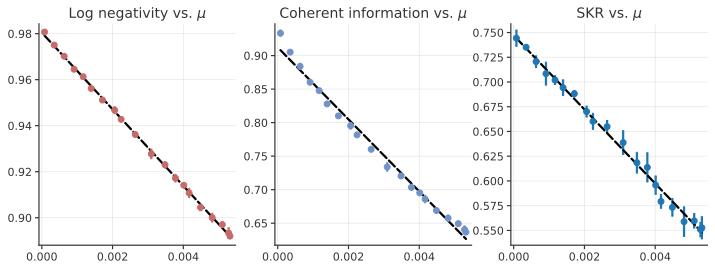

In [39]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(mus, log_neg_line(mus), 'k--')
ax[0].errorbar(mus, tomography_result.log_negativities.avg, yerr=tomography_result.log_negativities.std, fmt='o', color=Colors["red"] )

ax[1].plot(mus, coh_info_line(mus), 'k--')
ax[1].errorbar(mus, tomography_result.coherent_infos.avg, yerr=tomography_result.coherent_infos.std, fmt='o', color=Colors["blue"])




ax[2].errorbar(mus, skr/tomography_result.rates.avg, yerr= skr_std/tomography_result.rates.avg, fmt='o')


coeffs_skr_scalar = np.polyfit(mus, skr/tomography_result.rates.avg, 1)
skr_scalar_line = Line(coeffs_skr_scalar[0], coeffs_skr_scalar[1])


ax[2].plot(mus, skr_scalar_line(mus), 'k--')

ax[0].set_title(r"Log negativity vs. $\mu$")
ax[1].set_title(r"Coherent information vs. $\mu$")
ax[2].set_title(r"SKR vs. $\mu$")
# ax[2].errorbar(mus, tomography_result.rates.avg, yerr=tomography_result.rates.std, fmt='o', color=Colors["green"])

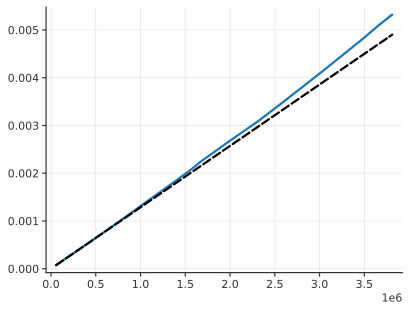

In [40]:
plt.plot(singles_B, mus)
fit = np.polyfit(singles_B[:3], mus[:3], 1)
fit_fn = np.poly1d(fit)
plt.plot(singles_B, fit_fn(singles_B), '--k')

In [41]:
def round_to_places(x, places):
    return round(x, places - int(np.floor(np.log10(x))) - 1)

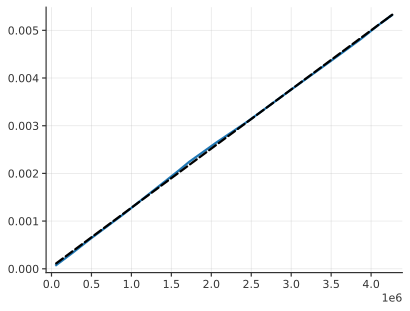

In [42]:
plt.plot(singles_B_linearized, mus)
fit = np.polyfit(singles_B_linearized, mus, 1)
fit_fn = np.poly1d(fit)
plt.plot(singles_B_linearized, fit_fn(singles_B_linearized), '--k')

max raw rates, diff single pixel:  755300.0
max secret key rate:  308700.0
max coherent info:  343700.0
max log negativity:  599600.0
(0.0, 0.0, 0.0, 0.5)
(0.2235294117647059, 0.35294117647058826, 0.20392156862745098, 0.5)
(0.24705882352941178, 0.3764705882352941, 0.6745098039215687, 0.5)
(0.611764705882353, 0.21568627450980393, 0.1843137254901961, 0.5)
dict_keys(['wavelengths', 'zero_subtracted', 'data_convolved', 'signal_full', 'idler_full', 'idler_8x', 'signal_8x', 'idler_16x', 'signal_16x'])
['..', 'figs', 'scan_extrapolate']
../figs/
pickleable


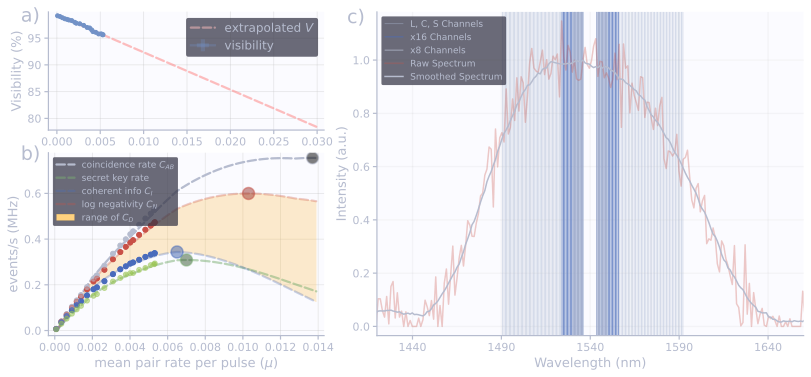

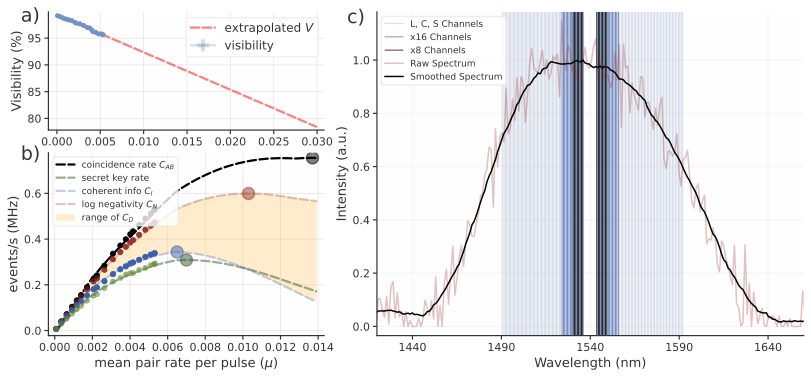

In [46]:
fig = plt.figure(figsize=(14 * 3 / 4, 6 * 3 / 4))
divider_width = 0.035

left, right = bisect(
    [0, 0, 1, 1],
    direction="vert",
    offset=0.4,
    spacing=divider_width * 2,
    absolute_spacing=True,
)


b, t = bisect(
    left,
    direction="horiz",
    offset=0.6,
    spacing=divider_width * 2,
    absolute_spacing=False,
)


ex_visibilities = fig.add_axes(t)
ex_rates = fig.add_axes(b)
spectrum = fig.add_axes(right)


singles_A_coeffs = np.polyfit(mus, singles_A_linearized, 1)
singles_A_line = Line(singles_A_coeffs[0], singles_A_coeffs[1])


def plot_extrapolated_visibilities(ax, res: TomoOutput, visibility_line: Line):
    mus_long = np.arange(1, 300) / 10000
    ax.plot(
        mus_long,
        visibility_line.slope * mus_long + visibility_line.intercept,
        color="red",
        linestyle="--",
        label=r"extrapolated $V$",
        alpha=0.5,
    )
    plot_visibilities(ax, mus, res, zoomed_out=True)
    ax.set_ylabel("Visibility (%)")
    legend = ax.legend(edgecolor="#e8e8e8")
    frame = legend.get_frame()
    frame.set_linewidth(1.25)


def hex_to_rgba(hex_color, alpha):
    hex_color = hex_color.lstrip("#")
    rgb = tuple(int(hex_color[i : i + 2], 16) / 255 for i in (0, 2, 4))
    print(rgb + (alpha,))
    return rgb + (alpha,)


@dataclass
class Point:
    mu: float
    rate: float


@dataclass
class Maxes:
    coherent_info: Point
    log_negativity: Point
    secret_key: Point
    raw_rate: Point


def plot_marker_at_max(ax, x, y, color, markersize=15) -> Point:
    y_loc = np.max(y)
    x_loc = x[np.argmax(y)]

    ax.plot(
        [x_loc],
        [y_loc],
        marker="o",
        color=color,
        markerfacecolor=hex_to_rgba(color, 0.5),
        markeredgewidth=1.5,
        markersize=markersize,
    )

    return Point(mu=x_loc, rate=y_loc)


def plot_extrapolated_rates(
    ax,
    res: TomoOutput,
    rates_line: Line,
    log_neg_line: Line,
    coh_info_line: Line,
    skr_scalar_line: Line,
) -> Maxes:
    
    mus_long = np.arange(1, 140) / 10000   # 0 to 0.01

    ef_eff = (
        np.interp(singles_A_line(mus_long), mcr_count_rates, mcr_eff_efficiencies) ** 2
    )

    diff_single_pixel_rates = rates_line(mus_long) * ef_eff
    # raw rates extrapolation
    ax.plot(
        mus_long,
        diff_single_pixel_rates / 1e6,
        color="black",
        linestyle="--",
        label=r"coincidence rate $C_{AB}$",
    )

    # secret key rate extrapolation
    secret_key_ln = skr_scalar_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        secret_key_ln / 1e6,
        color=Colors["dark_green"],
        linestyle="--",
        label="secret key rate",
        alpha=0.5,
    )

    # coherent info extrapolation

    coh_info_ln = coh_info_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        coh_info_ln / 1e6,
        color=Colors["dark_blue"],
        linestyle="--",
        label=r"coherent info $C_I$",
        alpha=0.3,
    )

    # log negativity extrapolation
    log_neg_ln = log_neg_line(mus_long) * diff_single_pixel_rates
    ax.plot(
        mus_long,
        log_neg_ln / 1e6,
        color=Colors["dark_red"],
        linestyle="--",
        label=r"log negativity $C_N$",
        alpha=0.3,
    )

    ax.fill_between(
        mus_long,
        log_neg_ln / 1e6,
        coh_info_ln / 1e6,
        alpha=0.2,
        color="orange",
        label=r"range of $C_D$",
    )

    # ax.set_ylim(0, 0.5)
    legend = ax.legend(edgecolor="#e8e8e8", fontsize=9)
    frame = legend.get_frame()
    frame.set_linewidth(1.25)

    print(
        "max raw rates, diff single pixel: ",
        round_to_places(np.max(diff_single_pixel_rates), 4),
    )
    print("max secret key rate: ", round_to_places(np.max(secret_key_ln), 4))
    print("max coherent info: ", round_to_places(np.max(coh_info_ln), 4))
    print("max log negativity: ", round_to_places(np.max(log_neg_ln), 4))

    raw_rates_max = plot_marker_at_max(
        ax, mus_long, diff_single_pixel_rates / 1e6, "#000000", markersize=12
    )
    secret_key_max = plot_marker_at_max(
        ax, mus_long, secret_key_ln / 1e6, Colors["dark_green"], markersize=12
    )
    coh_info_max = plot_marker_at_max(
        ax, mus_long, coh_info_ln / 1e6, Colors["dark_blue"], markersize=12
    )
    log_neg_max = plot_marker_at_max(
        ax, mus_long, log_neg_ln / 1e6, Colors["dark_red"], markersize=12
    )

    plot_rates(
        ax, mus, res, zoomed_out=True, line_style="none", marker="o", scalar=1e-6
    )

    mx = Maxes(
        coherent_info=coh_info_max,
        log_negativity=log_neg_max,
        secret_key=secret_key_max,
        raw_rate=raw_rates_max,
    )
    return mx


def plot_spectrum(ax):
    d = DataObj.from_file("spectrum_graph.json")
    for i, (signal, idler) in enumerate(zip(d.signal_full, d.idler_full)):
        if i == 0:
            ax.axvline(
                signal,
                color=Colors["light_blue"],
                alpha=0.6,
                lw=0.7,
                label="L, C, S Channels",
            )
        else:
            ax.axvline(signal, color=Colors["light_blue"], alpha=0.6, lw=0.7)
        ax.axvline(idler, color=Colors["light_blue"], alpha=0.6, lw=0.7)

    for i, (signal, idler) in enumerate(zip(d.signal_16x, d.idler_16x)):
        if i == 0:
            ax.axvline(
                signal,
                color=Colors["dark_blue"],
                alpha=0.8,
                lw=0.8,
                label="x16 Channels",
            )
        else:
            ax.axvline(signal, color=Colors["dark_blue"], alpha=0.8, lw=0.8)
        ax.axvline(idler, color=Colors["dark_blue"], alpha=0.8, lw=0.8)

    for i, (signal, idler) in enumerate(zip(d.signal_8x, d.idler_8x)):
        if i == 0:
            ax.axvline(signal, color="k", alpha=1, lw=0.7, label="x8 Channels")
        else:
            ax.axvline(signal, color="k", alpha=1, lw=0.7)
        ax.axvline(idler, color="k", alpha=1, lw=0.7)

    ax.plot(
        d.wavelengths,
        d.zero_subtracted / np.max(d.data_convolved),
        color=Colors["dark_red"],
        alpha=0.3,
        label="Raw Spectrum",
        lw=1.5,
    )
    ax.plot(
        d.wavelengths,
        d.data_convolved / np.max(d.data_convolved),
        color="k",
        lw=1.5,
        label="Smoothed Spectrum",
    )

    legend = ax.legend(edgecolor="#e8e8e8", fontsize=9)
    # legend = ax.legend(edgecolor="#e8e8e8",fontsize=9)
    frame = legend.get_frame()
    frame.set_linewidth(1.25)

    _ = ax.set_xticks(1540 + 50 * np.arange(-3, 3))
    ax.grid(alpha=0.1, lw=1.4)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_xlim(1540 - 120, 1540 + 120)
    ax.set_ylabel("Intensity (a.u.)")


plot_extrapolated_visibilities(ex_visibilities, tomography_result, visibility_line)
maxes = plot_extrapolated_rates(
    ex_rates,
    tomography_result,
    rates_line,
    log_neg_line,
    coh_info_line,
    skr_scalar_line,
)

ex_visibilities.text(
    -0.1, 1.04, "a)", transform=ex_visibilities.transAxes, fontsize=19, va="top"
)
ex_rates.text(-0.1, 1.04, "b)", transform=ex_rates.transAxes, fontsize=19, va="top")

ex_rates.set_ylabel(r"Event Rate (MHz)")
# ex_rates.set_ylim(0, 1)
# rates_legend = ex_rates.legend(loc="upper left", ncols=1) #, fancybox=False, frameon=False)
# rates_legend.get_frame().set_facecolor("none")

plot_spectrum(spectrum)

spectrum.text(-0.07, 1.01, "c)", transform=spectrum.transAxes, fontsize=19, va="top")

viz.save_light_dark_all(fig, "../figs/scan_extrapolate", override_alpha=True)

In [47]:
from enum import Enum

class CE(Enum):
    EIGHT = 1
    SIXTEEN = 2
    SIXTY = 3

d = DataObj.from_file("spectrum_graph.json")
interped_signal_full = np.interp(d.signal_full, d.wavelengths, d.data_convolved)
interped_idler_full = np.interp(d.idler_full, d.wavelengths, d.data_convolved)

interped_minimum = np.minimum(interped_signal_full, interped_idler_full)

# plt.plot(d.signal_full, interped_minimum)
# plt.plot(d.idler_full, interped_minimum)
# plt.ylim(0,np.max(interped_minimum))


def MHz_round(x, n):
    return round_to_nth(x,3)

def round_to_nth(x, n):
    return round(x, -int(np.floor(np.log10(x))) + (n - 1))

def extrapolate_channels_from_one(channel_rate, channel_ext: CE):
    
    # the raw coincidence rates at highest measured power for the 8 pairs
    x8_hp = np.array([436921, 471007, 390767, 461547, 414893, 496962, 390033, 497496])
    _40_54_4A = x8_hp[5] # the channel pair (40, 54) for which the shg scan was done


    # the main diagonal measured with one narroband filter and one x16 DWDM (KHz)
    x16 = [20.052, 21.606, 22.141, 21.592, 21.164, 22.997, 23.418, 23.117, 22.173, 21.975, 20.763, 23.159, 19.591, 22.471, 17.689, 20.274]
    _40_54 = x16[13] # the channel pair (40, 54) for which the shg scan was done


    if channel_ext == CE.EIGHT:
        ratio = channel_rate/_40_54_4A
        return MHz_round(ratio*np.sum(x8_hp),3)

    elif channel_ext == CE.SIXTEEN:
        ratio = channel_rate/_40_54
        return  MHz_round(ratio*np.sum(x16),3)

    elif channel_ext == CE.SIXTY:
        ratio = channel_rate/_40_54_4A
        channel_8 = ratio*np.sum(x8_hp)
        channel_8_spectrum = np.sum(interped_minimum[-8:])
        ratio_spectrum = channel_8/channel_8_spectrum
        return  MHz_round(ratio_spectrum*np.sum(interped_minimum),3)
    else:
        raise ValueError("Invalid channel_ext value: %s" % channel_ext)

def ex_ch(channel_rate, channel_ext: CE):
    return extrapolate_channels_from_one(channel_rate, channel_ext)

dict_keys(['wavelengths', 'zero_subtracted', 'data_convolved', 'signal_full', 'idler_full', 'idler_8x', 'signal_8x', 'idler_16x', 'signal_16x'])


In [48]:
maxes.coherent_info.rate

0.3437306771219283

In [49]:
from IPython.display import display, Markdown, Latex
display(Markdown(f"""
|metrics                                          | 1 channel                                | 8 channel                                    | 16 channel                                     | 60 channel                                   |
|-------------------------------------------------|------------------------------------------|----------------------------------------------|------------------------------------------------|----------------------------------------------|
| coincidence rate ({maxes.raw_rate.mu})          | {MHz_round(maxes.raw_rate.rate,3)}       | {ex_ch(maxes.raw_rate.rate, CE.EIGHT)}       | {ex_ch(maxes.raw_rate.rate, CE.SIXTEEN)}       | {ex_ch(maxes.raw_rate.rate, CE.SIXTY)}       |
| log negativity ({maxes.log_negativity.mu})      | {MHz_round(maxes.log_negativity.rate,8)} | {ex_ch(maxes.log_negativity.rate, CE.EIGHT)} | {ex_ch(maxes.log_negativity.rate, CE.SIXTEEN)} | {ex_ch(maxes.log_negativity.rate, CE.SIXTY)} |
| coherent information ({maxes.coherent_info.mu}) | {MHz_round(maxes.coherent_info.rate,8)}  | {ex_ch(maxes.coherent_info.rate, CE.EIGHT)}  | {ex_ch(maxes.coherent_info.rate, CE.SIXTEEN)}  | {ex_ch(maxes.coherent_info.rate, CE.SIXTY)}  |
| secret key rate ({maxes.secret_key.mu})         | {MHz_round(maxes.secret_key.rate,8)}     | {ex_ch(maxes.secret_key.rate, CE.EIGHT)}     | {ex_ch(maxes.secret_key.rate, CE.SIXTEEN)}     | {ex_ch(maxes.secret_key.rate, CE.SIXTY)}     |"""))


|metrics                                          | 1 channel                                | 8 channel                                    | 16 channel                                     | 60 channel                                   |
|-------------------------------------------------|------------------------------------------|----------------------------------------------|------------------------------------------------|----------------------------------------------|
| coincidence rate (0.0137)          | 0.755       | 5.41       | 11.6       | 34.9       |
| log negativity (0.0103)      | 0.6 | 4.29 | 9.18 | 27.7 |
| coherent information (0.0065) | 0.344  | 2.46  | 5.26  | 15.9  |
| secret key rate (0.007)         | 0.309     | 2.21     | 4.73     | 14.3     |

In [ ]:
np.sum(np.array([436921, 471007, 390767, 461547, 414893, 496962, 390033, 497496]))/1e6

3.559626

## Scrap

In [ ]:
power_idx = 19
iter_idx = 0

sect = power_steps[power_idx].phase_90[iter_idx]
Sa = np.sum(sect.singles_hist_1) / sect.delta_time
Sb = np.sum(sect.singles_hist_2) / sect.delta_time
Cc = sect.total_coincidences / sect.delta_time

In [ ]:
total_singles = (Sa + Sb) * 2
total_coincidences = Cc * 4